In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from itertools import combinations



In [16]:
df = pd.read_csv('C:/Users/Multiplexon/Desktop/data/d6/total 06.csv', sep=',')
df.head()


,Transaction Hash_len,Original_len,signature_len,From_len,To_len,sender_len,paymaster_len,Txn Fee,Gas Used,logIndex,actualGasCost,actualGasUsed,nonce,success,Blockno,DateTime_ts
0,32,1412,4,20,20,20,20,0.004663,360963,77,5.580000e+15,432020,6.0,1,18909051,1704069120
1,32,900,4,20,20,20,20,0.001098,97441,80,1.250000e+15,110855,33.0,1,18909074,1704069360
2,32,1636,4,20,20,20,20,0.003643,306649,60,4.450000e+15,374766,7.0,1,18909211,1704071040
3,32,1636,4,20,20,20,20,0.003438,281030,55,4.270000e+15,349159,8.0,1,18909215,1704071100
4,32,1636,4,20,20,20,20,0.001824,142131,155,2.110000e+15,164548,9.0,1,18909225,1704071220


In [17]:
# ================== IMPORTS ==================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# ================== CONFIG ==================
SEED = 42; np.random.seed(SEED)
PATH = "C:/Users/Multiplexon/Desktop/data/d6/total 06.csv"
FEATS = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

# OT + boosting (giống file 1)
ROUNDS   = 5
STAGE    = 400
K_LAST   = 2
LAM      = 0.03
N_Q      = 128
GLOBAL_CAP = 10000

LEAF_CAP   = 2000

# ================== LOAD DATA ==================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)
for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# ================== HELPERS ==================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def penalty_w2_quantile(residuals, inv, lam=0.1,
                        n_q=256, global_cap=10000, leaf_cap=2000, rng=None):
    if rng is None:
        rng = np.random.default_rng(SEED)
    res = residuals.ravel().astype(np.float64)
    if (global_cap is not None) and (res.size > global_cap):
        idxg = rng.choice(res.size, size=global_cap, replace=False)
        res_g = res[idxg]
    else:
        res_g = res
    qgrid = np.linspace(0.0, 1.0, n_q)
    q_all = np.quantile(res_g, qgrid)

    n_leaves = int(inv.max()) + 1
    pen = np.zeros(n_leaves, dtype=np.float64)
    for i in range(n_leaves):
        r = res[inv == i]
        if r.size == 0: continue
        if (leaf_cap is not None) and (r.size > leaf_cap):
            idx = rng.choice(r.size, size=leaf_cap, replace=False)
            r = r[idx]
        q_leaf = np.quantile(r, qgrid)
        w2 = np.mean((q_leaf - q_all) ** 2)
        pen[i] = lam * w2
    return pen

# ================== K-FOLD CROSS VALIDATION ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

metrics_all = []   # lưu kết quả từng fold

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\n===== Fold {fold} =====")

    # Train/test split cho fold này
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y_raw[train_idx], y_raw[test_idx]

    # Fit MinMaxScaler cho target train
    y_mm_scaler = MinMaxScaler()
    y_train_mm = y_mm_scaler.fit_transform(y_train_raw.reshape(-1,1)).ravel()
    y_test_mm  = y_mm_scaler.transform(y_test_raw.reshape(-1,1)).ravel()

    # Feature impute + scale
    X_train[~np.isfinite(X_train)] = np.nan
    X_test[~np.isfinite(X_test)]   = np.nan
    imp = SimpleImputer(strategy="median").fit(X_train)
    X_train_imp = imp.transform(X_train)
    X_test_imp  = imp.transform(X_test)
    scaler = MinMaxScaler().fit(X_train_imp)
    X_train_s = scaler.transform(X_train_imp).astype(np.float32)
    X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

    # Target log cho training
    y_train = np.log1p(y_train_raw.astype(np.float64))
    y_test  = np.log1p(y_test_raw.astype(np.float64))

    # Training loop with OT reweight
    w = np.ones(len(y_train), dtype=np.float64)
    model = None
    for r in range(1, ROUNDS+1):
        iters = (model.tree_count_ if model is not None else 0) + STAGE
        booster = CatBoostRegressor(
            iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
            loss_function="RMSE", random_seed=SEED, verbose=False,
            allow_writing_files=False, thread_count=-1
        )
        booster.fit(X_train_s, y_train, sample_weight=w,
                    init_model=None if model is None else model)
        model = booster

        # residuals
        res = y_train - model.predict(X_train_s)

        # leaf groups
        leaf_idx = model.calc_leaf_indexes(
            X_train_s,
            ntree_start=max(model.tree_count_-K_LAST,0),
            ntree_end=model.tree_count_,
            thread_count=-1
        )
        leaf_idx = np.asarray(leaf_idx)
        if leaf_idx.ndim == 1:
            leaf_idx = leaf_idx.reshape(-1,1)
        codes = combine_last_k_leaf_ids(leaf_idx, k_last=K_LAST)
        _, inv = np.unique(codes, return_inverse=True)

        # penalty + update weights
        pen = penalty_w2_quantile(residuals=res, inv=inv, lam=LAM,
                                  n_q=N_Q, global_cap=GLOBAL_CAP, leaf_cap=LEAF_CAP)
        w *= np.exp(-pen[inv])
        w /= (w.mean() + 1e-12)
        w = np.clip(w, 1e-3, 50.0)

    # Final prediction trên fold này
    y_pred_raw = np.expm1(model.predict(X_test_s))
    y_pred_mm  = y_mm_scaler.transform(y_pred_raw.reshape(-1,1)).ravel()

    # Metrics trên MinMaxScale
    mse  = mean_squared_error(y_test_mm, y_pred_mm)
    rmse = mean_squared_error(y_test_mm, y_pred_mm, squared=False)
    mae  = mean_absolute_error(y_test_mm, y_pred_mm)
    r2   = r2_score(y_test_mm, y_pred_mm)

    print(f"Fold {fold} [MinMax]: RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R2={r2:.6f}")
    metrics_all.append([rmse, mse, mae, r2])

# ================== TỔNG HỢP KẾT QUẢ ==================
metrics_all = np.array(metrics_all)
print("\n=== 10-FOLD AVERAGE (MinMax) ===")
print("RMSE:", metrics_all[:,0].mean())
print("MSE :", metrics_all[:,1].mean())
print("MAE :", metrics_all[:,2].mean())
print("R2  :", metrics_all[:,3].mean())



===== Fold 1 =====
Fold 1 [MinMax]: RMSE=0.004820, MSE=0.000023, MAE=0.002176, R2=0.843573

===== Fold 2 =====
Fold 2 [MinMax]: RMSE=0.004376, MSE=0.000019, MAE=0.002180, R2=0.863907

===== Fold 3 =====
Fold 3 [MinMax]: RMSE=0.009905, MSE=0.000098, MAE=0.003340, R2=0.745819

===== Fold 4 =====
Fold 4 [MinMax]: RMSE=0.005396, MSE=0.000029, MAE=0.002207, R2=0.812841

===== Fold 5 =====
Fold 5 [MinMax]: RMSE=0.005572, MSE=0.000031, MAE=0.002209, R2=0.803869

===== Fold 6 =====
Fold 6 [MinMax]: RMSE=0.005164, MSE=0.000027, MAE=0.002212, R2=0.821506

===== Fold 7 =====
Fold 7 [MinMax]: RMSE=0.004014, MSE=0.000016, MAE=0.002171, R2=0.883330

===== Fold 8 =====
Fold 8 [MinMax]: RMSE=0.005458, MSE=0.000030, MAE=0.002210, R2=0.810797

===== Fold 9 =====
Fold 9 [MinMax]: RMSE=0.005393, MSE=0.000029, MAE=0.002230, R2=0.810774

===== Fold 10 =====
Fold 10 [MinMax]: RMSE=0.005517, MSE=0.000030, MAE=0.002195, R2=0.814829

=== 10-FOLD AVERAGE (MinMax) ===
RMSE: 0.005561427814617073
MSE : 3.327336393

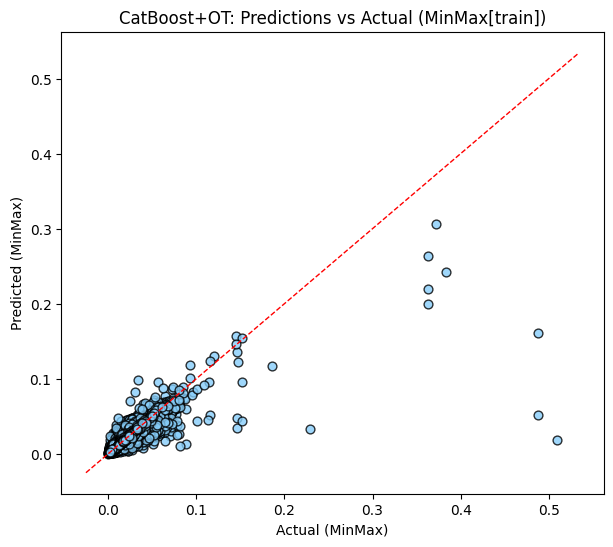

In [18]:
# ================== SCATTER (MinMax[train]) ==================
import matplotlib.pyplot as plt

# y_true/y_pred trên thang MinMax (đã có từ phần đánh giá cuối)
y_true_mm = y_test_mm
y_pred_mm = y_pred_test_mm

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_true_mm, y_pred_mm, s=40, alpha=0.8, color="lightskyblue", edgecolors="k")

# Vẽ đường y = x theo giới hạn hiện tại của trục
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lo, hi = min(x0, y0), max(x1, y1)
ax.plot([lo, hi], [lo, hi], "--", linewidth=1,color="red")

ax.set_title("CatBoost+OT: Predictions vs Actual (MinMax[train])")
ax.set_xlabel("Actual (MinMax)")
ax.set_ylabel("Predicted (MinMax)")
plt.show()

In [ ]:
# ================== IMPORTS ==================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# ================== CONFIG (match file 1) ==================
SEED = 42; np.random.seed(SEED)
PATH = "C:/Users/Multiplexon/Desktop/data/d6/total 06.csv"
FEATS  = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

# OT + boosting (giống file 1)
ROUNDS   = 5
STAGE    = 400
K_LAST   = 2
LAM      = 0.03
N_Q      = 128
GLOBAL_CAP = 10000
LEAF_CAP   = 2000

# early stopping
VAL_SIZE = 0.2
OD_WAIT  = 100

# Epochs mong muốn
EPOCHS = 20

# ================== LOAD DATA ==================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)
for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X_all   = df[FEATS].to_numpy(dtype=np.float64)
y_raw_all = df[TARGET].to_numpy(dtype=np.float64)

# ================== HELPERS (giống file 1) ==================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def penalty_w2_quantile(residuals, inv, lam=0.1, n_q=256,
                        global_cap=10000, leaf_cap=2000, rng=None):
    if rng is None:
        rng = np.random.default_rng(SEED)
    res = residuals.ravel().astype(np.float64)
    if (global_cap is not None) and (res.size > global_cap):
        res_g = res[rng.choice(res.size, size=global_cap, replace=False)]
    else:
        res_g = res
    qgrid = np.linspace(0.0, 1.0, n_q)
    q_all = np.quantile(res_g, qgrid)

    n_leaves = int(inv.max()) + 1
    pen = np.zeros(n_leaves, dtype=np.float64)
    for i in range(n_leaves):
        r = residuals[inv == i]
        if r.size == 0:
            continue
        if (leaf_cap is not None) and (r.size > leaf_cap):
            r = r[rng.choice(r.size, size=leaf_cap, replace=False)]
        q_leaf = np.quantile(r, qgrid)
        w2 = np.mean((q_leaf - q_all) ** 2)
        pen[i] = lam * w2
    return pen

# ================== 10 EPOCHS × 10-FOLD CV ==================
xg = np.zeros((EPOCHS, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]
rng_global = np.random.default_rng(SEED)

for ep in range(EPOCHS):
    # permute toàn bộ dữ liệu trước KFold (để các fold thực tế khác nhau giữa các epoch)
    idx = rng_global.permutation(len(X_all))
    X_ep   = X_all[idx]
    y_ep_r = y_raw_all[idx]

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for tr_idx, te_idx in kf.split(X_ep):
        # --- dữ liệu fold ---
        X_train_full, X_test = X_ep[tr_idx], X_ep[te_idx]
        y_train_full_raw, y_test_raw = y_ep_r[tr_idx], y_ep_r[te_idx]

        # target scaler cho EVAL (fit trên train-fold)
        y_mm_scaler = MinMaxScaler().fit(y_train_full_raw.reshape(-1,1))
        y_test_mm   = y_mm_scaler.transform(y_test_raw.reshape(-1,1)).ravel()

        # clean + impute + scale (fit trên train-fold)
        X_train_full[~np.isfinite(X_train_full)] = np.nan
        X_test[~np.isfinite(X_test)]             = np.nan
        imp = SimpleImputer(strategy="median").fit(X_train_full)
        X_train_imp = imp.transform(X_train_full)
        X_test_imp  = imp.transform(X_test)

        scaler = MinMaxScaler().fit(X_train_imp)
        X_train_s = scaler.transform(X_train_imp).astype(np.float32)
        X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

        # target transform cho TRAIN (log1p)
        y_train_full = np.log1p(y_train_full_raw.astype(np.float64))

        # tách VAL nội bộ cho early stopping (model train trên FULL train-fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_s, y_train_full, test_size=VAL_SIZE, random_state=SEED
        )

        # ====== TRAIN + OT-REWEIGHT (FULL TRAIN-FOLD, CPU continuation) ======
        w_full = np.ones(X_train_s.shape[0], dtype=np.float64)
        model = None

        for r in range(1, ROUNDS + 1):
            iters = (model.tree_count_ if model is not None else 0) + STAGE
            booster = CatBoostRegressor(
                iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
                loss_function="RMSE", random_state=SEED, verbose=False,
                allow_writing_files=False, thread_count=-1,
                od_type='Iter', od_wait=OD_WAIT, use_best_model=True
                # NOTE: để giữ đúng continuation, KHÔNG bật GPU ở đây
            )
            booster.fit(
                X_train_s, y_train_full,
                sample_weight=w_full,
                init_model=None if model is None else model,
                eval_set=(X_val, y_val)
            )
            model = booster

            # residuals & leaf groups trên FULL train-fold
            res_full = y_train_full - model.predict(X_train_s)
            leaf_idx_full = model.calc_leaf_indexes(
                X_train_s,
                ntree_start=max(model.tree_count_ - K_LAST, 0),
                ntree_end=model.tree_count_,
                thread_count=-1
            )
            leaf_idx_full = np.asarray(leaf_idx_full)
            if leaf_idx_full.ndim == 1:
                leaf_idx_full = leaf_idx_full.reshape(-1, 1)
            codes_full = combine_last_k_leaf_ids(leaf_idx_full, k_last=K_LAST)
            _, inv_full = np.unique(codes_full, return_inverse=True)

            pen_full = penalty_w2_quantile(
                residuals=res_full, inv=inv_full, lam=LAM,
                n_q=N_Q, global_cap=GLOBAL_CAP, leaf_cap=LEAF_CAP
            )

            # cập nhật trọng số
            w_full *= np.exp(-pen_full[inv_full])
            w_full /= (w_full.mean() + 1e-12)
            w_full = np.clip(w_full, 1e-3, 50.0)

        # ====== PREDICT & METRICS trên TEST-fold ======
        y_pred_test_raw = np.expm1(model.predict(X_test_s))
        y_pred_test_mm  = y_mm_scaler.transform(y_pred_test_raw.reshape(-1,1)).ravel()

        mse  = mean_squared_error(y_test_mm, y_pred_test_mm)
        rmse = mean_squared_error(y_test_mm, y_pred_test_mm, squared=False)
        mae  = mean_absolute_error(y_test_mm, y_pred_test_mm)
        r2   = r2_score(y_test_mm, y_pred_test_mm)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    # tổng hợp theo 10 fold cho epoch này
    xg[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]
    
# ================== OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(xg, separator=', ', prefix='array(') + ")")

final_mean = xg.mean(axis=0)
final_std  = xg.std(axis=0, ddof=1)
print("\nMean over 10 epochs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 10 epochs (RMSE, MSE, MAE, R2):", final_std)


array([[5.56544562e-03, 3.27274952e-05, 2.30997385e-03, 8.19712366e-01],
       [5.52037382e-03, 3.27273119e-05, 2.31173908e-03, 8.23296848e-01],
       [5.54803360e-03, 3.32828669e-05, 2.31215035e-03, 8.22403623e-01],
       [5.54755515e-03, 3.27142746e-05, 2.31080634e-03, 8.21844799e-01],
       [5.47010821e-03, 3.17685977e-05, 2.30954576e-03, 8.25304682e-01],
       [5.51920793e-03, 3.29315312e-05, 2.31394735e-03, 8.23946933e-01],
       [5.54697949e-03, 3.27515918e-05, 2.31456370e-03, 8.21481121e-01],
       [5.51259606e-03, 3.30798527e-05, 2.31296797e-03, 8.25433877e-01],
       [5.46410413e-03, 3.12982503e-05, 2.30891240e-03, 8.25471207e-01],
       [5.54267725e-03, 3.31539464e-05, 2.31263629e-03, 8.22054481e-01],
       [5.49868431e-03, 3.18715544e-05, 2.31004681e-03, 8.22896852e-01],
       [5.44005653e-03, 3.06853923e-05, 2.31148905e-03, 8.25011561e-01],
       [5.54013709e-03, 3.43623165e-05, 2.31203192e-03, 8.25103366e-01],
       [5.48971271e-03, 3.14336531e-05, 2.31196184e

In [1]:
#entrypoint address v07
# ================== IMPORTS ==================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# ================== CONFIG ==================
SEED = 42; np.random.seed(SEED)
PATH = "C:/Users/Multiplexon/Desktop/data/d7/total 7.csv"
FEATS = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

# OT + boosting (giống file 1)
ROUNDS   = 5
STAGE    = 400
K_LAST   = 2
LAM      = 0.03
N_Q      = 128
GLOBAL_CAP = 10000

LEAF_CAP   = 2000

# ================== LOAD DATA ==================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)
for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X = df[FEATS].to_numpy(dtype=np.float64)
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# ================== HELPERS ==================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def penalty_w2_quantile(residuals, inv, lam=0.1,
                        n_q=256, global_cap=10000, leaf_cap=2000, rng=None):
    if rng is None:
        rng = np.random.default_rng(SEED)
    res = residuals.ravel().astype(np.float64)
    if (global_cap is not None) and (res.size > global_cap):
        idxg = rng.choice(res.size, size=global_cap, replace=False)
        res_g = res[idxg]
    else:
        res_g = res
    qgrid = np.linspace(0.0, 1.0, n_q)
    q_all = np.quantile(res_g, qgrid)

    n_leaves = int(inv.max()) + 1
    pen = np.zeros(n_leaves, dtype=np.float64)
    for i in range(n_leaves):
        r = res[inv == i]
        if r.size == 0: continue
        if (leaf_cap is not None) and (r.size > leaf_cap):
            idx = rng.choice(r.size, size=leaf_cap, replace=False)
            r = r[idx]
        q_leaf = np.quantile(r, qgrid)
        w2 = np.mean((q_leaf - q_all) ** 2)
        pen[i] = lam * w2
    return pen

# ================== K-FOLD CROSS VALIDATION ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

metrics_all = []   # lưu kết quả từng fold

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\n===== Fold {fold} =====")

    # Train/test split cho fold này
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y_raw[train_idx], y_raw[test_idx]

    # Fit MinMaxScaler cho target train
    y_mm_scaler = MinMaxScaler()
    y_train_mm = y_mm_scaler.fit_transform(y_train_raw.reshape(-1,1)).ravel()
    y_test_mm  = y_mm_scaler.transform(y_test_raw.reshape(-1,1)).ravel()

    # Feature impute + scale
    X_train[~np.isfinite(X_train)] = np.nan
    X_test[~np.isfinite(X_test)]   = np.nan
    imp = SimpleImputer(strategy="median").fit(X_train)
    X_train_imp = imp.transform(X_train)
    X_test_imp  = imp.transform(X_test)
    scaler = MinMaxScaler().fit(X_train_imp)
    X_train_s = scaler.transform(X_train_imp).astype(np.float32)
    X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

    # Target log cho training
    y_train = np.log1p(y_train_raw.astype(np.float64))
    y_test  = np.log1p(y_test_raw.astype(np.float64))

    # Training loop with OT reweight
    w = np.ones(len(y_train), dtype=np.float64)
    model = None
    for r in range(1, ROUNDS+1):
        iters = (model.tree_count_ if model is not None else 0) + STAGE
        booster = CatBoostRegressor(
            iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
            loss_function="RMSE", random_seed=SEED, verbose=False,
            allow_writing_files=False, thread_count=-1
        )
        booster.fit(X_train_s, y_train, sample_weight=w,
                    init_model=None if model is None else model)
        model = booster

        # residuals
        res = y_train - model.predict(X_train_s)

        # leaf groups
        leaf_idx = model.calc_leaf_indexes(
            X_train_s,
            ntree_start=max(model.tree_count_-K_LAST,0),
            ntree_end=model.tree_count_,
            thread_count=-1
        )
        leaf_idx = np.asarray(leaf_idx)
        if leaf_idx.ndim == 1:
            leaf_idx = leaf_idx.reshape(-1,1)
        codes = combine_last_k_leaf_ids(leaf_idx, k_last=K_LAST)
        _, inv = np.unique(codes, return_inverse=True)

        # penalty + update weights
        pen = penalty_w2_quantile(residuals=res, inv=inv, lam=LAM,
                                  n_q=N_Q, global_cap=GLOBAL_CAP, leaf_cap=LEAF_CAP)
        w *= np.exp(-pen[inv])
        w /= (w.mean() + 1e-12)
        w = np.clip(w, 1e-3, 50.0)

    # Final prediction trên fold này
    y_pred_raw = np.expm1(model.predict(X_test_s))
    y_pred_mm  = y_mm_scaler.transform(y_pred_raw.reshape(-1,1)).ravel()

    # Metrics trên MinMaxScale
    mse  = mean_squared_error(y_test_mm, y_pred_mm)
    rmse = mean_squared_error(y_test_mm, y_pred_mm, squared=False)
    mae  = mean_absolute_error(y_test_mm, y_pred_mm)
    r2   = r2_score(y_test_mm, y_pred_mm)

    print(f"Fold {fold} [MinMax]: RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R2={r2:.6f}")
    metrics_all.append([rmse, mse, mae, r2])

# ================== TỔNG HỢP KẾT QUẢ ==================
metrics_all = np.array(metrics_all)
print("\n=== 10-FOLD AVERAGE (MinMax) ===")
print("RMSE:", metrics_all[:,0].mean())
print("MSE :", metrics_all[:,1].mean())
print("MAE :", metrics_all[:,2].mean())
print("R2  :", metrics_all[:,3].mean())



===== Fold 1 =====
Fold 1 [MinMax]: RMSE=0.002482, MSE=0.000006, MAE=0.001088, R2=0.910705

===== Fold 2 =====
Fold 2 [MinMax]: RMSE=0.002349, MSE=0.000006, MAE=0.001083, R2=0.921977

===== Fold 3 =====
Fold 3 [MinMax]: RMSE=0.002262, MSE=0.000005, MAE=0.001072, R2=0.931013

===== Fold 4 =====
Fold 4 [MinMax]: RMSE=0.012094, MSE=0.000146, MAE=0.001264, R2=0.368071

===== Fold 5 =====
Fold 5 [MinMax]: RMSE=0.002388, MSE=0.000006, MAE=0.001063, R2=0.921609

===== Fold 6 =====
Fold 6 [MinMax]: RMSE=0.002526, MSE=0.000006, MAE=0.001092, R2=0.911545

===== Fold 7 =====
Fold 7 [MinMax]: RMSE=0.002774, MSE=0.000008, MAE=0.001111, R2=0.893533

===== Fold 8 =====
Fold 8 [MinMax]: RMSE=0.012314, MSE=0.000152, MAE=0.001201, R2=0.339333

===== Fold 9 =====
Fold 9 [MinMax]: RMSE=0.002558, MSE=0.000007, MAE=0.001074, R2=0.913266

===== Fold 10 =====
Fold 10 [MinMax]: RMSE=0.002265, MSE=0.000005, MAE=0.001066, R2=0.926223

=== 10-FOLD AVERAGE (MinMax) ===
RMSE: 0.0044012121694479754
MSE : 3.46143724

In [ ]:
#run 20 times
# ================== IMPORTS ==================
import numpy as np, pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# ================== CONFIG (match file 1) ==================
SEED = 42; np.random.seed(SEED)
PATH = "C:/Users/Multiplexon/Desktop/data/d7/total 7.csv"
FEATS  = ['Original_len','Txn Fee','logIndex','actualGasCost','Blockno','DateTime_ts','nonce']
TARGET = 'Gas Used'

# OT + boosting (giống file 1)
ROUNDS   = 5
STAGE    = 400
K_LAST   = 2
LAM      = 0.03
N_Q      = 128
GLOBAL_CAP = 10000
LEAF_CAP   = 2000

# early stopping
VAL_SIZE = 0.2
OD_WAIT  = 100

# Epochs mong muốn
EPOCHS = 20

# ================== LOAD DATA ==================
use_cols = FEATS + [TARGET]
df = pd.read_csv(PATH, usecols=lambda c: c in use_cols)
for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[df[TARGET] < -1, TARGET] = np.nan
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

X_all   = df[FEATS].to_numpy(dtype=np.float64)
y_raw_all = df[TARGET].to_numpy(dtype=np.float64)

# ================== HELPERS (giống file 1) ==================
def combine_last_k_leaf_ids(leaf_mat, k_last=1):
    L = np.asarray(leaf_mat)
    if L.ndim == 1:
        return L.astype(np.int64)
    k = max(1, min(int(k_last), L.shape[1]))
    sub = L[:, -k:]
    base = int(sub.max()) + 1
    powers = (base ** np.arange(sub.shape[1], dtype=np.int64))
    return (sub.astype(np.int64) * powers).sum(axis=1)

def penalty_w2_quantile(residuals, inv, lam=0.1, n_q=256,
                        global_cap=10000, leaf_cap=2000, rng=None):
    if rng is None:
        rng = np.random.default_rng(SEED)
    res = residuals.ravel().astype(np.float64)
    if (global_cap is not None) and (res.size > global_cap):
        res_g = res[rng.choice(res.size, size=global_cap, replace=False)]
    else:
        res_g = res
    qgrid = np.linspace(0.0, 1.0, n_q)
    q_all = np.quantile(res_g, qgrid)

    n_leaves = int(inv.max()) + 1
    pen = np.zeros(n_leaves, dtype=np.float64)
    for i in range(n_leaves):
        r = residuals[inv == i]
        if r.size == 0:
            continue
        if (leaf_cap is not None) and (r.size > leaf_cap):
            r = r[rng.choice(r.size, size=leaf_cap, replace=False)]
        q_leaf = np.quantile(r, qgrid)
        w2 = np.mean((q_leaf - q_all) ** 2)
        pen[i] = lam * w2
    return pen

# ================== 10 EPOCHS × 10-FOLD CV ==================
xg = np.zeros((EPOCHS, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]
rng_global = np.random.default_rng(SEED)

for ep in range(EPOCHS):
    # permute toàn bộ dữ liệu trước KFold (để các fold thực tế khác nhau giữa các epoch)
    idx = rng_global.permutation(len(X_all))
    X_ep   = X_all[idx]
    y_ep_r = y_raw_all[idx]

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for tr_idx, te_idx in kf.split(X_ep):
        # --- dữ liệu fold ---
        X_train_full, X_test = X_ep[tr_idx], X_ep[te_idx]
        y_train_full_raw, y_test_raw = y_ep_r[tr_idx], y_ep_r[te_idx]

        # target scaler cho EVAL (fit trên train-fold)
        y_mm_scaler = MinMaxScaler().fit(y_train_full_raw.reshape(-1,1))
        y_test_mm   = y_mm_scaler.transform(y_test_raw.reshape(-1,1)).ravel()

        # clean + impute + scale (fit trên train-fold)
        X_train_full[~np.isfinite(X_train_full)] = np.nan
        X_test[~np.isfinite(X_test)]             = np.nan
        imp = SimpleImputer(strategy="median").fit(X_train_full)
        X_train_imp = imp.transform(X_train_full)
        X_test_imp  = imp.transform(X_test)

        scaler = MinMaxScaler().fit(X_train_imp)
        X_train_s = scaler.transform(X_train_imp).astype(np.float32)
        X_test_s  = scaler.transform(X_test_imp).astype(np.float32)

        # target transform cho TRAIN (log1p)
        y_train_full = np.log1p(y_train_full_raw.astype(np.float64))

        # tách VAL nội bộ cho early stopping (model train trên FULL train-fold)
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_s, y_train_full, test_size=VAL_SIZE, random_state=SEED
        )

        # ====== TRAIN + OT-REWEIGHT (FULL TRAIN-FOLD, CPU continuation) ======
        w_full = np.ones(X_train_s.shape[0], dtype=np.float64)
        model = None

        for r in range(1, ROUNDS + 1):
            iters = (model.tree_count_ if model is not None else 0) + STAGE
            booster = CatBoostRegressor(
                iterations=iters, depth=8, learning_rate=0.05, l2_leaf_reg=5,
                loss_function="RMSE", random_state=SEED, verbose=False,
                allow_writing_files=False, thread_count=-1,
                od_type='Iter', od_wait=OD_WAIT, use_best_model=True
                # NOTE: để giữ đúng continuation, KHÔNG bật GPU ở đây
            )
            booster.fit(
                X_train_s, y_train_full,
                sample_weight=w_full,
                init_model=None if model is None else model,
                eval_set=(X_val, y_val)
            )
            model = booster

            # residuals & leaf groups trên FULL train-fold
            res_full = y_train_full - model.predict(X_train_s)
            leaf_idx_full = model.calc_leaf_indexes(
                X_train_s,
                ntree_start=max(model.tree_count_ - K_LAST, 0),
                ntree_end=model.tree_count_,
                thread_count=-1
            )
            leaf_idx_full = np.asarray(leaf_idx_full)
            if leaf_idx_full.ndim == 1:
                leaf_idx_full = leaf_idx_full.reshape(-1, 1)
            codes_full = combine_last_k_leaf_ids(leaf_idx_full, k_last=K_LAST)
            _, inv_full = np.unique(codes_full, return_inverse=True)

            pen_full = penalty_w2_quantile(
                residuals=res_full, inv=inv_full, lam=LAM,
                n_q=N_Q, global_cap=GLOBAL_CAP, leaf_cap=LEAF_CAP
            )

            # cập nhật trọng số
            w_full *= np.exp(-pen_full[inv_full])
            w_full /= (w_full.mean() + 1e-12)
            w_full = np.clip(w_full, 1e-3, 50.0)

        # ====== PREDICT & METRICS trên TEST-fold ======
        y_pred_test_raw = np.expm1(model.predict(X_test_s))
        y_pred_test_mm  = y_mm_scaler.transform(y_pred_test_raw.reshape(-1,1)).ravel()

        mse  = mean_squared_error(y_test_mm, y_pred_test_mm)
        rmse = mean_squared_error(y_test_mm, y_pred_test_mm, squared=False)
        mae  = mean_absolute_error(y_test_mm, y_pred_test_mm)
        r2   = r2_score(y_test_mm, y_pred_test_mm)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    # tổng hợp theo 10 fold cho epoch này
    xg[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]
    
# ================== OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(xg, separator=', ', prefix='array(') + ")")

final_mean = xg.mean(axis=0)
final_std  = xg.std(axis=0, ddof=1)
print("\nMean over 10 epochs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 10 epochs (RMSE, MSE, MAE, R2):", final_std)
